In [1]:
import numpy as np
import cv2
import rawpy
from pyzbar.pyzbar import decode as zbar_decode
import time
from glob import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = [25, 25]

### Minimal waste zbar decoding

Barcode decoding using zbar (or in this case pyzbar, a zbar wrapper) is rotationally sensitive, with a tolerance of about 15 degress. The common solution to this drawback is to attempt a series of rotations until results are found. This has a few drawbacks:
 - the more skewed a barcode is, the longer the process takes.
 - This process cannot identify multiple barcodes on angles differing > 15 degrees, unless all rotations are attempted every time.
 
However, zbar works by scanning rows and columns and only takes into account one of axis at a time. Which means it is always scanning vectors either 1 pixel tall or 1 pixel wide. The basic idea is to identify vectors across the image likely to contain the barcode values and pass them in an organized manner to zbar. The basic idea is illustrated in the cell below: where a single row of a tightly croped, straight barcode is quickly decoded using pyzbar. The challenge is the properly identify the vectors to pass to pyzbar.

(442, 3)


[Decoded(data=b'00030725', type='CODE39', rect=Rect(left=0, top=6, width=2, height=432), polygon=[Point(x=0, y=438), Point(x=2, y=438), Point(x=1, y=6)])]

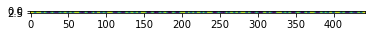

In [2]:
slim_bc_im = cv2.imread('./exampleImages/various_images/slim_BC.jpg')
# slice out a single row
single_row = slim_bc_im[2]
print(single_row.shape)
# now we have an image with a single row, 422 cols, and 3 chanels
imshow(single_row.T)
zbar_decode(single_row)

#### Barcode containing vector identification by parallell lines

Given barcodes are made up of a series of parallell lines, Houghlines were initially explored for the itentification of parallell lines. However I was not able to generalize the open cv `houghlines()` and `houghlinesp()` functions enough to be both fast and robust.

#### Barcode containing vector identification by geometry

Since barcodes are also essentially a series of boxes the following process was developed with success:
 - Perform basic processing to remove noise and simplify lines.
 - Identify generally "square" objects using canny edge detection and contour detection
 - Calculate a vector intersecting the midpoints of each squares' parallell lines.
 - Extend said vector both directions of said vector by a non arbitary value.
     - In this case example 1/6th of either height or width of imput image (whichever is smaller).
     - Since this is extended in both directions the assumption is that the barcode will be < 1/3rd of the smaller dimension.
 - For each vector (2 per square identified):
     - Sample pixel values along the extended vector.
 - Join all sampled vector pixels, vertically into a new single image
 - Pass the new image to a modified pyzbar wrapper for zbar.
     - Modification exposes the x_density, y_density configure options as parameters in `decode()`.
     - By setting y_density=0, and  x_density=1 we effectively tell zbar to scan every horizontal line and skip vertical scans.

#### Define the many helper functions necessary:

In [3]:
def openImageFile(imgPath):
    # taken from postProcessing.py, used to represent typical input conditions for our use case.
    # notice we were not able to make it function on half_size (consistant with the 'old' method.)
        raw_base = rawpy.imread(imgPath)
        im = raw_base.postprocess(output_color=rawpy.ColorSpace.raw,
                                  #half_size=True,
                                  use_auto_wb=False,
                                  user_wb=[1, 0.5, 1, 0],
                                  no_auto_bright=True,
                                  demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR
                                  )
        raw_base.close()
        return im

def angle_cos(p0, p1, p2):
    # Utalized in find_squares, from opencv samples    
    d1, d2 = (p0 - p1).astype('float'), (p2 - p1).astype('float')
    return abs(np.dot(d1, d2) / np.sqrt(np.dot(d1, d1) * np.dot(d2, d2)))

def find_squares(img):
    # Modified from: opencv samples    
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.erode(img, (5,5), iterations = 1)
    img = cv2.dilate(img, (5,5), iterations = 1)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv2.split(img):
        #for thrs in range(0, 255, 6):
        for thrs in range(0, 255, 18):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02 * cnt_len, True)
                contourArea = cv2.contourArea(cnt)
                if len(cnt) == 4 and contourArea > 500 and contourArea < 100000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos(cnt[i], cnt[(i + 1) % 4], cnt[(i + 2) % 4]) for i in range(4)])
                    if max_cos < 0.2:
                        squares.append(cnt)
    return squares

def merge_proposals(images):
    min_pix_length = 10
    images = [x for x in images if x.shape[0] > min_pix_length]
    height = max(image.shape[0] for image in images) +1
    width = len(images) + 1
    #print(f'merged proposals shaped: {height, width}')
    output = np.zeros((height,width)).astype('uint8')
    y = 0
    for image in images:
        h = image.shape[0] - 1
        w = 1
        output[0:h+1, y+w] = image
        y += w 
    return output

def det_midpoint(p1, p2):
    return int((p1[0]+p2[0])/2), int((p1[1]+p2[1])/2)

def det_centroid_intersection(square):
    a, b, c, d = square
    ab_mid = det_midpoint(a, b)
    cd_mid = det_midpoint(c, d)
    da_mid = det_midpoint(d, a)
    bc_mid = det_midpoint(b, c)
    return ab_mid, cd_mid, da_mid, bc_mid

def extend_vector(p1, p2, h, w, extend=500):

    theta = np.arctan2(p1[1]-p2[1], p1[0]-p2[0])
    endpt_x = max(0, min(p1[0] - extend*np.cos(theta), w))
    endpt_y = max(0, min(p1[1] - extend*np.sin(theta), h))

    theta = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])
    startpt_x = max(0, min(p2[0] - extend*np.cos(theta), w))
    startpt_y = max(0, min(p2[1] - extend*np.sin(theta), h))
    return startpt_x, startpt_y, endpt_x, endpt_y

def extract_vector_coords(x1, y1, x2, y2, h, w):
    # https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array
    length = int(np.hypot(x2-x1, y2-y1))-1
    x = np.linspace(x1, x2, length)
    x = np.rint(x).astype(int)
    y = np.linspace(y1, y2, length)
    y = np.rint(y).astype(int)
    pix_coords = y, x
    return pix_coords

#### Define the actual decode function which, given an image returns the barcode data.
This version of the function draws squares and vectors on the imput image, which is returned for debugging and demonstration.

In [4]:
def extract_by_squares_debug(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # ID squares
    squares = find_squares(gray)
    #print(f'square qty: {len(squares)}')
    #for debugging
    cv2.drawContours( img, squares, -1, (0, 255, 0), 3 )
    # iterate over each and det their midpoint intersects
    h, w = img.shape[0:2]
    h -=1
    w -=1
    line_data = []
    # extension happens in both directions, therefore effectively doubled.
    extend = min(h,w) // 6
    for square in squares:
        a, b, c, d = square
        ab_mid = det_midpoint(a, b)
        cd_mid = det_midpoint(c, d)
        x1, y1, x2, y2 = extend_vector(ab_mid, cd_mid, h, w, extend=extend)
        #for debugging
        cv2.line(img,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),1)
        pix_coords = extract_vector_coords(x1, y1, x2, y2, h, w)
        zi = gray[pix_coords]
        line_data.append(zi)

        da_mid = det_midpoint(d, a)
        bc_mid = det_midpoint(b, c)
        x1, y1, x2, y2 = extend_vector(da_mid, bc_mid, h, w, extend=extend)
        #for debugging
        cv2.line(img,(int(x1),int(y1)),(int(x2),int(y2)),(0, 0,255),1)
        
        pix_coords = extract_vector_coords(x1, y1, x2, y2, h, w)
        zi = gray[pix_coords]
        line_data.append(zi)

    merged_lines = merge_proposals(line_data)
    z = zbar_decode(merged_lines, y_density=0, x_density=1)
    return z, img, merged_lines

#### Test the function on a single image and display the visualizations of the intermediate results

[Decoded(data=b'UCHT043121', type='CODE39', rect=Rect(left=2, top=273, width=173, height=377), polygon=[Point(x=2, y=650), Point(x=175, y=447), Point(x=169, y=273), Point(x=81, y=275), Point(x=49, y=354)])]


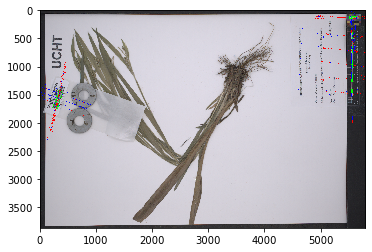

In [5]:
imPath = './exampleImages/UCHT_test_set/UCHT_med_noBlur_angleBC.CR2'
im = openImageFile(imPath)
z, img, merged_lines = extract_by_squares_debug(im)
print(z)
imshow(img)

# store these images for later.
#cv2.imwrite('onsheet_vectors.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#cv2.imwrite('merged_vectors.jpg', cv2.cvtColor(merged_lines, cv2.COLOR_RGB2BGR))

#### Display the generated merged_lines image which is passed to zbar. 
*Note:* the image is transposed 90 degrees here for ease of displaying. It is normally passed as a tall image.

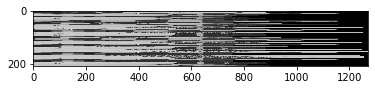

In [6]:
imshow(merged_lines.T, cmap='gray')

#### Redefine the function without the debugging / demonstration considerations.

In [7]:
def extract_by_squares(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # ID squares
    squares = find_squares(gray)
    # iterate over each and det their midpoint intersects
    h, w = img.shape[0:2]
    h -=1
    w -=1
    line_data = []
    # extension happens in both directions, therefore effectively doubled.
    extend = min(h,w) // 6
    for square in squares:
        a, b, c, d = square
        ab_mid = det_midpoint(a, b)
        cd_mid = det_midpoint(c, d)
        x1, y1, x2, y2 = extend_vector(ab_mid, cd_mid, h, w, extend=extend)
        pix_coords = extract_vector_coords(x1, y1, x2, y2, h, w)
        zi = gray[pix_coords]
        line_data.append(zi)

        da_mid = det_midpoint(d, a)
        bc_mid = det_midpoint(b, c)
        x1, y1, x2, y2 = extend_vector(da_mid, bc_mid, h, w, extend=extend)

        pix_coords = extract_vector_coords(x1, y1, x2, y2, h, w)
        zi = gray[pix_coords]
        line_data.append(zi)

    merged_lines = merge_proposals(line_data)
    z = zbar_decode(merged_lines, y_density=0, x_density=1)
    return z

#### Test the function on a lot of images

In [8]:
from glob import glob
import time
from pyzbar import pyzbar


new_process_times = []
new_process_acc = []
old_process_times = []
old_process_acc = []

ucht_images = glob('./exampleImages/UCHT_test_set/*.CR2')
mobot_images = glob('./exampleImages/MOBOT_test_set/*.CR2')
images = ucht_images + mobot_images

for x in range(8):
    for i, image in enumerate(images):   
        if image == './exampleImages/UCHT_test_set/corrupt.CR2':
            continue
        # open the image file
        im = openImageFile(image)
        ###
        # start timing the new process
        ###
        start = time.time()
        z = extract_by_squares(im)
        end = time.time() - start
        new_process_times.append(end)
        if z != []:
            result = True
        else:
            result = False
        new_process_acc.append(result)

        ###
        # start timing the old process
        ###
        start = time.time()
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        z = pyzbar.decode(im)
        end = time.time() - start
        old_process_times.append(end)
        if z != []:
            result = True
        else:
            result = False
        old_process_acc.append(result)

###
#  Report the results
# while background processes may interfere, we run trials in alternating treatments
# the assumption is interferences is relatively evently distributed.
###
total_runs = len(new_process_acc)
print(f'Over {total_runs} total runs:')

avg_new_process_times = np.mean(new_process_times)
print(f'avg_new_process runtime = {avg_new_process_times}')
# accuracy denom is reduced by 1 to account for the one known example with no bc.
new_acc = sum(new_process_acc) / (len(new_process_acc)-1)
print(f'new process acc = {new_acc}')

avg_old_process_times = np.mean(old_process_times)
print(f'avg_old_process_times runtime = {avg_old_process_times}')
# accuracy denom is reduced by 1 to account for the one known example with no bc.
old_acc = sum(old_process_acc) / (len(old_process_acc)-1)
print(f'old process acc = {old_acc}')

Over 192 total runs:
avg_new_process runtime = 0.6191934359570345
new process acc = 0.8795811518324608
avg_old_process_times runtime = 0.8710398264229298
old process acc = 0.7958115183246073


### Only 'very high blur' failed and those fail both new and old processes. 

Although it cannot perform on half resolution, neither can the original method. It is still an improvement!

### Testing the differences in postprocess times with and without half_size flag.

In [9]:
half_times = []
full_times = []

imPath = './exampleImages/UCHT_test_set/UCHT_med_noBlur_angleBC.CR2'
raw_base = rawpy.imread(imPath)

for i in range(50):
    start = time.time()
    im = raw_base.postprocess(output_color=rawpy.ColorSpace.raw,
                              half_size=True,
                              use_auto_wb=False,
                              user_wb=[1, 0.5, 1, 0],
                              no_auto_bright=True,
                              demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR
                              )
    end = time.time() - start
    half_times.append(end)

    start = time.time()
    im = raw_base.postprocess(output_color=rawpy.ColorSpace.raw,
                              #half_size=True,
                              use_auto_wb=False,
                              user_wb=[1, 0.5, 1, 0],
                              no_auto_bright=True,
                              demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR
                              )
    end = time.time() - start
    full_times.append(end)

raw_base.close()

avg_half_times = np.mean(half_times)
print(f'avg_half_times: {avg_half_times}')
avg_full_times = np.mean(full_times)
print(f'avg_full_times: {avg_full_times}')

avg_half_times: 0.2545444345474243
avg_full_times: 1.2924159622192384
